In [1]:
# shap environment
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_friedman1  
from copy import deepcopy
from lightgbm import LGBMRegressor
import sklearn

#### Helper functions

In [2]:
np.set_printoptions(precision=3)

def estimators_mse(model, X, y):
    mse = []
    if type(model) is sklearn.ensemble._gb.GradientBoostingRegressor:
        print('Ensemble should be convex combination of extimators: GradientBoosting is not supported!')
    else:
        for e in model.estimators_:
            mse.append(((y - e.predict(X))**2).sum()/len(X))
    return np.array(mse)

def estimators_amb(model, X):
    ambiguity = []
    ens = model.predict(X)
    if type(model) is sklearn.ensemble._gb.GradientBoostingRegressor:
        print('Ensemble should be convex combination of extimators: GradientBoosting is not supported!')
    else:
        for e in model.estimators_:
            ambiguity.append(((e.predict(X) - ens)**2).sum()/len(X))
    return np.array(ambiguity)

In [216]:
def mse_amb_plot(m, title, X_train, y_train, X_test, y_test):
    mse_train = estimators_mse(m, X_train, y_train)
    amb_train = estimators_amb(m, X_train)
    err_train = []

    mse_test = estimators_mse(m, X_test, y_test)
    amb_test = estimators_amb(m, X_test)
    err_test = []
    
    if type(m) is sklearn.ensemble._gb.GradientBoostingRegressor:
        err_train.append(mse_train[0] - amb_train[0])
        err_test.append(mse_test[0] - amb_test[0])
        for i in range(1,m.n_estimators):
            err_train.append((mse_train[i] - amb_train[i]) * m.learning_rate)
            err_test.append((mse_test[i] - amb_test[i]) * m.learning_rate)
    
    else:
        for i in range(0,m.n_estimators):
            err_train.append((mse_train[i] - amb_train[i]) / m.n_estimators)
            err_test.append((mse_test[i] - amb_test[i]) / m.n_estimators)
        
    ymin = min(mse_train.min(), amb_train.min())-1
    ymax = max(mse_test.max(), amb_test.max())+1
    median = np.arange(ymin,ymax,(ymax-ymin) / 10)

    fig = plt.figure(figsize=(15, 5), dpi = 200)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5]) 
    
    ax0 = plt.subplot(gs[0])
    plt.scatter(mse_train,amb_train, marker = 'o', color = 'b', label = 'train')
    plt.scatter(mse_test,amb_test, marker = 'x', color = 'g', label = 'test')
    plt.ylim(ymin,ymax)
    plt.xlim(ymin,ymax)
    plt.plot(median, median, color = 'r')
    plt.xlabel('Mean squared error', fontsize = 12)
    plt.ylabel('Ambuguity', fontsize = 12)
    plt.legend()
    
    ax1 = plt.subplot(gs[1])
    index = np.arange(m.n_estimators)
    bar_width = 0.35

    plt.bar(index, err_train, bar_width, color = 'b', label = 'Train')
    plt.bar(index + bar_width, err_test, bar_width, color = 'g', label = 'Test')
    plt.xticks(np.arange(0, m.n_estimators, 1.0) )
    plt.xlabel("Estimator's no ($i$)", fontsize = 12)
    plt.ylabel('$w_{i}[e_{i} - a_{i}]$', fontsize = 12)
    plt.legend()
    
    e_tr = '{:.3f}'.format(sum(err_train))
    e_te = '{:.3f}'.format(sum(err_test))
    plt.suptitle(title + ' ($e_{train} = $' + e_tr + ', $e_{test}$ =' + e_te + ')', fontsize = 12) #, fontweight = 'bold')

In [4]:
def cv_score(model, X, y, cv = 4):
    kf = KFold(n_splits = cv)
    result_test = []
    result_train = []
    for train_index, test_index in kf.split(X, y):
        model.fit(X[train_index], y[train_index])
        result_train.append(mean_squared_error(y[train_index], model.predict(X[train_index])))
        result_test.append(mean_squared_error(y[test_index], model.predict(X[test_index])))
    return np.array(result_test), np.array(result_train)

#### Managing Ambiguity Regressor

In [55]:
class est_mean:
    def __init__(self):
        self.mean_y = None
        
    def fit(self, X, y):
        self.mean_y = y.mean()
        
    def predict(self, X):
        return np.full(X.shape[0],self.mean_y)
        
class ManagingAmbiguityRegressor:
    def __init__(self, base_estimator = DecisionTreeRegressor(max_depth = 1), n_estimators = 20):
        self.n_estimators = n_estimators
        self.estimator = base_estimator
        self.fitted = False
        self.estimators_ = []
        
    def fit(self,X,y):
        self.estimators_ = []
        est0 = self.estimator.fit(X,y)
        self.estimators_.append(deepcopy(est0))
        sum_est = est0.predict(X)
        for m in range(2, self.n_estimators + 1):
            est = self.estimator
            est.fit(X, m * y - sum_est)
            self.estimators_.append(deepcopy(est))
            sum_est += est.predict(X)
        self.fitted = True

    def predict(self,X):
        f = np.zeros(X.shape[0])
        for est in self.estimators_:
            f += est.predict(X)
        return f / len(self.estimators_)

#### Create dataset

In [60]:
X, y = make_friedman1(n_samples = 10000, n_features=20, noise = 0.1, random_state = 1)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state= 2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10000, 20) (10000,)
(7500, 20) (7500,)
(2500, 20) (2500,)


#### Optimizing models

In [61]:
import optuna
import time

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_gb(trial):
    lr = trial.suggest_float("lr", 0.1, 0.5, log = True)
    ne = trial.suggest_int("n_est", 10, 200)
    md = trial.suggest_int('md', 1, 10)
    reg = LGBMRegressor(boosting_type='gbdt', max_depth = md, learning_rate = lr, n_estimators = ne, n_jobs = -1, random_state = 101)
    res, _ = cv_score(reg, X, y, cv = 10)
    trial.set_user_attr("std", res.std())
    print('#', end = '')
    return res.mean()

def objective_sgb(trial):
    lr = trial.suggest_float("lr", 0.1, 0.5, log = True)
    ne = trial.suggest_int("n_est", 10, 200)
    md = trial.suggest_int('md', 1, 10)
    ms = trial.suggest_float("ms", 0.8, 1.0)
    mf = trial.suggest_float("mf", 0.8, 1.0)
    reg = LGBMRegressor(boosting_type='gbdt', max_depth = md, learning_rate = lr, n_estimators = ne, n_jobs = -1,
                        subsample = ms, colsample_bytree =  mf, random_state = 101)
    res, _ = cv_score(reg, X, y, cv = 10)
    trial.set_user_attr("std", res.std())
    print('#', end = '')
    return res.mean()

def objective_dart(trial):
    lr = trial.suggest_float("lr", 0.1, 0.5, log = True)
    ne  = trial.suggest_int("n_est", 10, 200)  
    md  = trial.suggest_int('md', 1,10)   
    reg = LGBMRegressor(boosting_type='dart', max_depth = md, learning_rate = lr, n_estimators = ne, n_jobs = -1, random_state = 101)
    res, _ = cv_score(reg, X, y, cv = 10)
    trial.set_user_attr("std", res.std())
    print('#', end = '')
    return res.mean()

def objective_sdart(trial): 
    lr = trial.suggest_float("lr", 0.1, 0.5, log = True)
    ne  = trial.suggest_int("n_est", 10, 200)  
    md  = trial.suggest_int('md', 1,10)   
    mf = trial.suggest_float("mf", 0.75, 1.0, log = True)
    ms = trial.suggest_float("ms", 0.75, 1.0, log = True)
    reg = LGBMRegressor(boosting_type='dart', max_depth = md, learning_rate = lr, n_estimators = ne, n_jobs = -1, 
                        subsample = ms, colsample_bytree =  mf, random_state = 101)
    res, _ = cv_score(reg, X, y, cv = 10)
    trial.set_user_attr("std", res.std())
    print('#', end = '')
    return res.mean()

def objective_rf(trial):
    ne = trial.suggest_int("n_est", 10, 200)  
    mf = trial.suggest_float("mf", 0.67, 1.0, log = True)
    ms = trial.suggest_float("ms", 0.67, 1.0, log = True)
    reg = RandomForestRegressor(n_estimators = ne, max_features = mf, max_samples = ms, n_jobs = -1, random_state = 101)
    res, _ = cv_score(reg, X, y, cv = 10)
    trial.set_user_attr("std", res.std())
    print('#', end = '')
    return res.mean()

def objective_br(trial):
    ne = trial.suggest_int("n_est", 10, 200)  
    mf = trial.suggest_float("mf", 0.75, 1.0, log = True)
    ms = trial.suggest_float("ms", 0.66, 1.0, log = True)
    reg = BaggingRegressor(n_estimators = ne, max_features = mf, max_samples = 1.0, n_jobs = -1, random_state = 101)
    res, _ = cv_score(reg, X, y, cv = 10)
    trial.set_user_attr("std", res.std())
    print('#', end = '')
    return res.mean()

def objective_ma(trial):
    ne  = trial.suggest_int("n_est", 10, 200)  
    md  = trial.suggest_int('md', 1,10)   
    reg = ManagingAmbiguityRegressor(base_estimator = DecisionTreeRegressor(max_depth = md, random_state = 101), n_estimators = ne)
    res, _ = cv_score(reg, X, y, cv = 10)
    trial.set_user_attr("std", res.std())
    print('#', end = '')
    return res.mean()

studies = {}

targets = {'GB' : objective_gb, 'SGB' : objective_sgb, 'DART' : objective_dart, 'SDART' : objective_sdart, 
           'MA' : objective_ma, 'RF' : objective_rf, 'BR' : objective_br}

for target in targets:
    print(target, '  ', end = '')
    start = time.time()
    s = optuna.create_study(direction = 'minimize')
    s.optimize(targets[target], n_trials = 25)
    print()
    print(f'Best trial: {s.best_trial.value :5.3f} ({s.best_trial.user_attrs["std"] :5.3f}) time = {time.time() - start :.1f} sec')
    for p in s.best_trial.params:
        print(p, '=', s.best_trial.params[p], '; ', end = '')
    print()
    print()
    studies[target] = s

GB   #########################
Best trial: 0.201 (0.011) time = 59.1 sec
lr = 0.11282754165737899 ; n_est = 163 ; md = 5 ; 

SGB   #########################
Best trial: 0.165 (0.007) time = 69.5 sec
lr = 0.10223379475622835 ; n_est = 200 ; md = 7 ; ss = 0.8724097884566483 ; mf = 0.8454985278678391 ; 

DART   #########################
Best trial: 0.138 (0.007) time = 152.6 sec
lr = 0.24924417561379134 ; n_est = 166 ; md = 9 ; 

SDART   #########################
Best trial: 0.115 (0.009) time = 163.9 sec
lr = 0.29718436381258645 ; n_est = 164 ; md = 6 ; mf = 0.833547795904324 ; ms = 0.882911233493531 ; 

MA   #########################
Best trial: 0.064 (0.004) time = 3776.3 sec
n_est = 190 ; md = 5 ; 

RF   #########################
Best trial: 1.302 (0.070) time = 1481.8 sec
n_est = 157 ; mf = 0.8039866295513602 ; ms = 0.9990408745126863 ; 

BR   #########################
Best trial: 1.348 (0.071) time = 2347.7 sec
n_est = 192 ; mf = 0.9633802122364771 ; ms = 0.9036007238209626 ; 



| Model | Loss          | M   |   LR  | MD | Samples | Features |
|-------|---------------|-----|-------|----|---------|----------|
| GB    | 0.201 (0.011) | 163 | 0.113 | 5  | -       | -        |
| SGB   | 0.165 (0.007) | 200 | 0.102 | 7  | 0.872   | 0.845    |
| DART  | 0.138 (0.007) | 166 | 0.249 | 9  | -       | -        |
| SDART | 0.115 (0.009) | 164 | 0.297 | 6  | 0.883   | 0.834    |
| BR    | 1.348 (0.071) | 192 | -     | -  | 0.904   | 0.963    |
| RF    | 1.302 (0.070) | 157 | -     | -  | 0.999   | 0.804    |
| MA    | 0.064 (0.004) | 190 | -     | 5  | -       | -        |

#### Comparing with Gradient Boosting (Fig.1)

In [220]:
models = {'GB'   : LGBMRegressor(boosting_type='gbdt', max_depth = studies['GB'].best_trial.params['md'], 
                                 learning_rate = studies['GB'].best_trial.params['lr'], n_estimators = studies['GB'].best_trial.params['n_est'], 
                                 n_jobs = -1, random_state = 101),
          'SGB'  : LGBMRegressor(boosting_type='gbdt', max_depth = studies['SGB'].best_trial.params['md'], learning_rate = studies['SGB'].best_trial.params['lr'], 
                                 n_estimators = studies['SGB'].best_trial.params['n_est'], subsample = studies['SGB'].best_trial.params['ss'], 
                                 colsample_bytree =  studies['SGB'].best_trial.params['mf'], n_jobs = -1, random_state = 101),
          'DART' : LGBMRegressor(boosting_type='dart', max_depth = studies['DART'].best_trial.params['md'], learning_rate = studies['DART'].best_trial.params['lr'],
                                 n_estimators = studies['DART'].best_trial.params['n_est'], n_jobs = -1, random_state = 101),
          'SDART': LGBMRegressor(boosting_type='dart', max_depth = studies['SDART'].best_trial.params['md'], learning_rate = studies['SDART'].best_trial.params['lr'],
                                 n_estimators = studies['SDART'].best_trial.params['n_est'], subsample = studies['SDART'].best_trial.params['ms'], 
                                 colsample_bytree =  studies['SDART'].best_trial.params['mf'], n_jobs = -1,random_state = 101),
          'MA'   : ManagingAmbiguityRegressor(base_estimator = DecisionTreeRegressor(max_depth = studies['MA'].best_trial.params['md'], random_state = 101), 
                                              n_estimators = studies['MA'].best_trial.params['n_est']),
          'RF'   : RandomForestRegressor(n_estimators = studies['RF'].best_trial.params['n_est'], max_features = studies['RF'].best_trial.params['mf'], 
                                         max_samples = studies['RF'].best_trial.params['ms'], n_jobs = -1, random_state = 101),
          'BR'   : RandomForestRegressor(n_estimators = studies['BR'].best_trial.params['n_est'], max_features = studies['BR'].best_trial.params['mf'], 
                                         max_samples = studies['BR'].best_trial.params['ms'], n_jobs = -1, random_state = 101)
          } 

for model in models:
    models[model].fit(X_train, y_train)
    print(f'{model :5s}: {mean_squared_error(y_train, models[model].predict(X_train)) :5.3f}, {mean_squared_error(y_test, models[model].predict(X_test)) :5.3f}')

GB   : 0.089, 0.238
SGB  : 0.057, 0.191
DART : 0.051, 0.164
SDART: 0.041, 0.137
MA   : 0.009, 0.072
RF   : 0.199, 1.491
BR   : 0.245, 1.515


In [221]:
# MSE change for LightGBM

def LGBM_predictions(model, X, y):
    mse_, mse_impr  = [],[]
    for i in range(1,model.n_estimators + 1):
        mse_.append(mean_squared_error(y, model.predict(X, start_iteration = 0, num_iteration = i, raw_score = True)))
    for i in range(1,len(mse_)):
        mse_impr.append((mse_[i-1] - mse_[i]) / mse_[i-1]) 
    return np.array(mse_), np.array(mse_impr)

# Managing Ambiguity

def MA_predictions(model, X, y):
    y_pred_ = np.zeros(X.shape[0])
    mse_, mse_impr  = [], []
    for m, e in enumerate(model.estimators_):
        y_pred_ += e.predict(X)
        mse_.append(mean_squared_error(y, y_pred_ / (m + 1)))
    for i in range(1,len(mse_)):
        mse_impr.append((mse_[i-1] - mse_[i]) / mse_[i-1]) 
    return np.array(mse_), np.array(mse_impr)

mse_GB,    impr_GB    = LGBM_predictions(models['GB'], X_test, y_test)
mse_SGB,   impr_SGB   = LGBM_predictions(models['SGB'], X_test, y_test)
mse_DART,  impr_DART  = LGBM_predictions(models['DART'], X_test, y_test)
mse_SDART, impr_SDART = LGBM_predictions(models['SDART'], X_test, y_test)
mse_MA,    impr_MA    = MA_predictions(models['MA'], X_test, y_test)

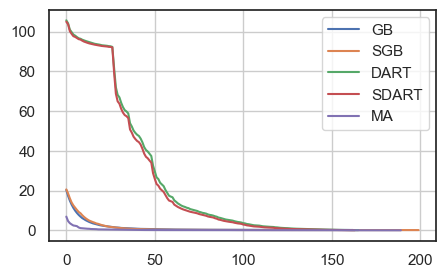

In [222]:
_ = plt.figure(figsize = (5,3))
plt.plot(mse_GB, label = 'GB');
plt.plot(mse_SGB, label = 'SGB');
plt.plot(mse_DART, label = 'DART');
plt.plot(mse_SDART, label = 'SDART');
plt.plot(mse_MA, label = 'MA');
plt.legend();
plt.grid();

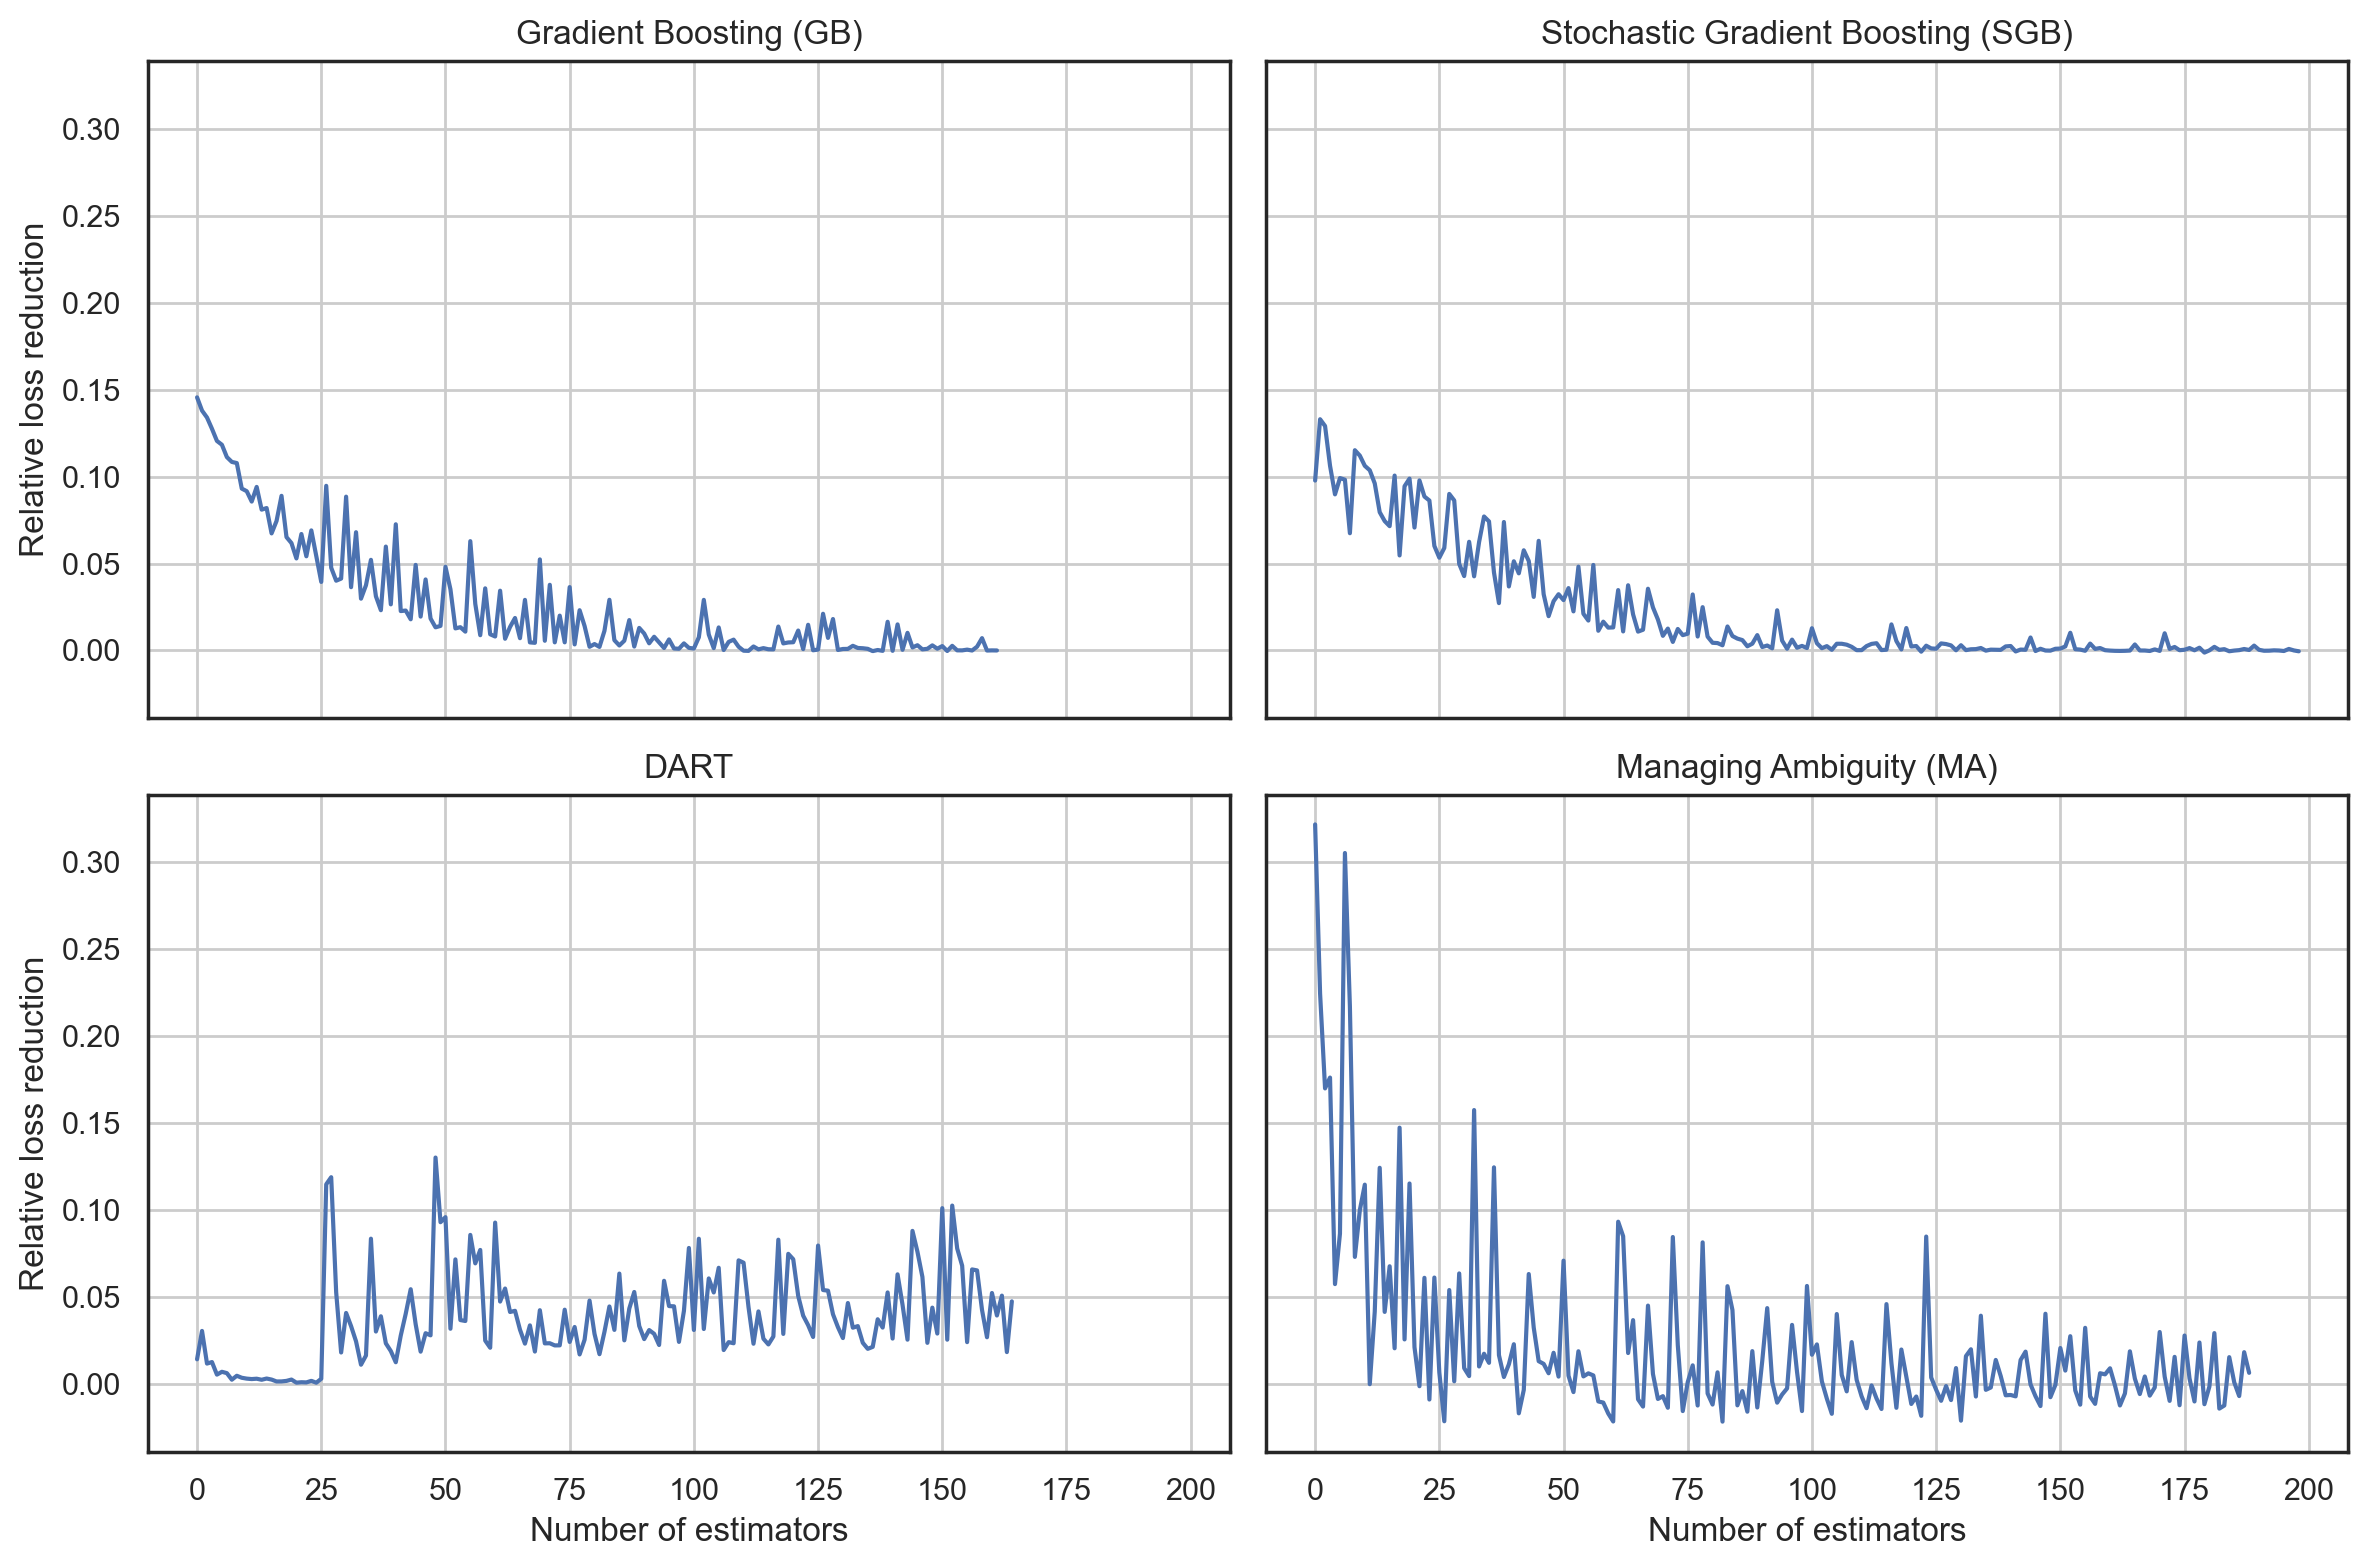

In [223]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8), sharey = True, sharex = True, dpi = 200);
ax[0,0].plot(impr_GB, label = 'MA');
ax[0,0].grid();
ax[0,0].set_title("Gradient Boosting (GB)");
ax[0,0].set_ylabel('Relative loss reduction');
ax[0,1].plot(impr_SGB, label = 'GB');
ax[0,1].grid();
ax[0,1].set_title("Stochastic Gradient Boosting (SGB)");
ax[1,0].plot(impr_DART, label = 'DART');
ax[1,0].grid();
ax[1,0].set_title("DART");
ax[1,0].set_xlabel('Number of estimators');
ax[1,0].set_ylabel('Relative loss reduction');
ax[1,1].plot(impr_MA);
ax[1,1].grid();
ax[1,1].set_title("Managing Ambiguity (MA)");
ax[1,1].set_xlabel('Number of estimators');
fig.tight_layout();

#### Comparing with Bagging / Random Forest (Fig. 2, 3)

In [224]:
n = 25

models25 = {'rf' : RandomForestRegressor(n_estimators = n, max_features = studies['RF'].best_trial.params['mf'], 
                                         max_samples = studies['RF'].best_trial.params['ms'], n_jobs = -1, random_state = 101), 
            'ma' : ManagingAmbiguityRegressor(base_estimator = DecisionTreeRegressor(max_depth = studies['MA'].best_trial.params['md'], random_state = 101), 
                                              n_estimators = n),
            'gb' : GradientBoostingRegressor(max_depth = studies['GB'].best_trial.params['md'], learning_rate = studies['GB'].best_trial.params['lr'], 
                                             n_estimators = n, random_state = 101),
           }
                                            

for model in models25:
    models25[model].fit(X_train, y_train)
    print('%3s: %6.3f %6.3f' %(model, mean_squared_error(y_train, models25[model].predict(X_train)),
                                      mean_squared_error(y_test, models25[model].predict(X_test))))

 rf:  0.256  1.592
 ma:  0.220  0.432
 gb:  1.488  2.034


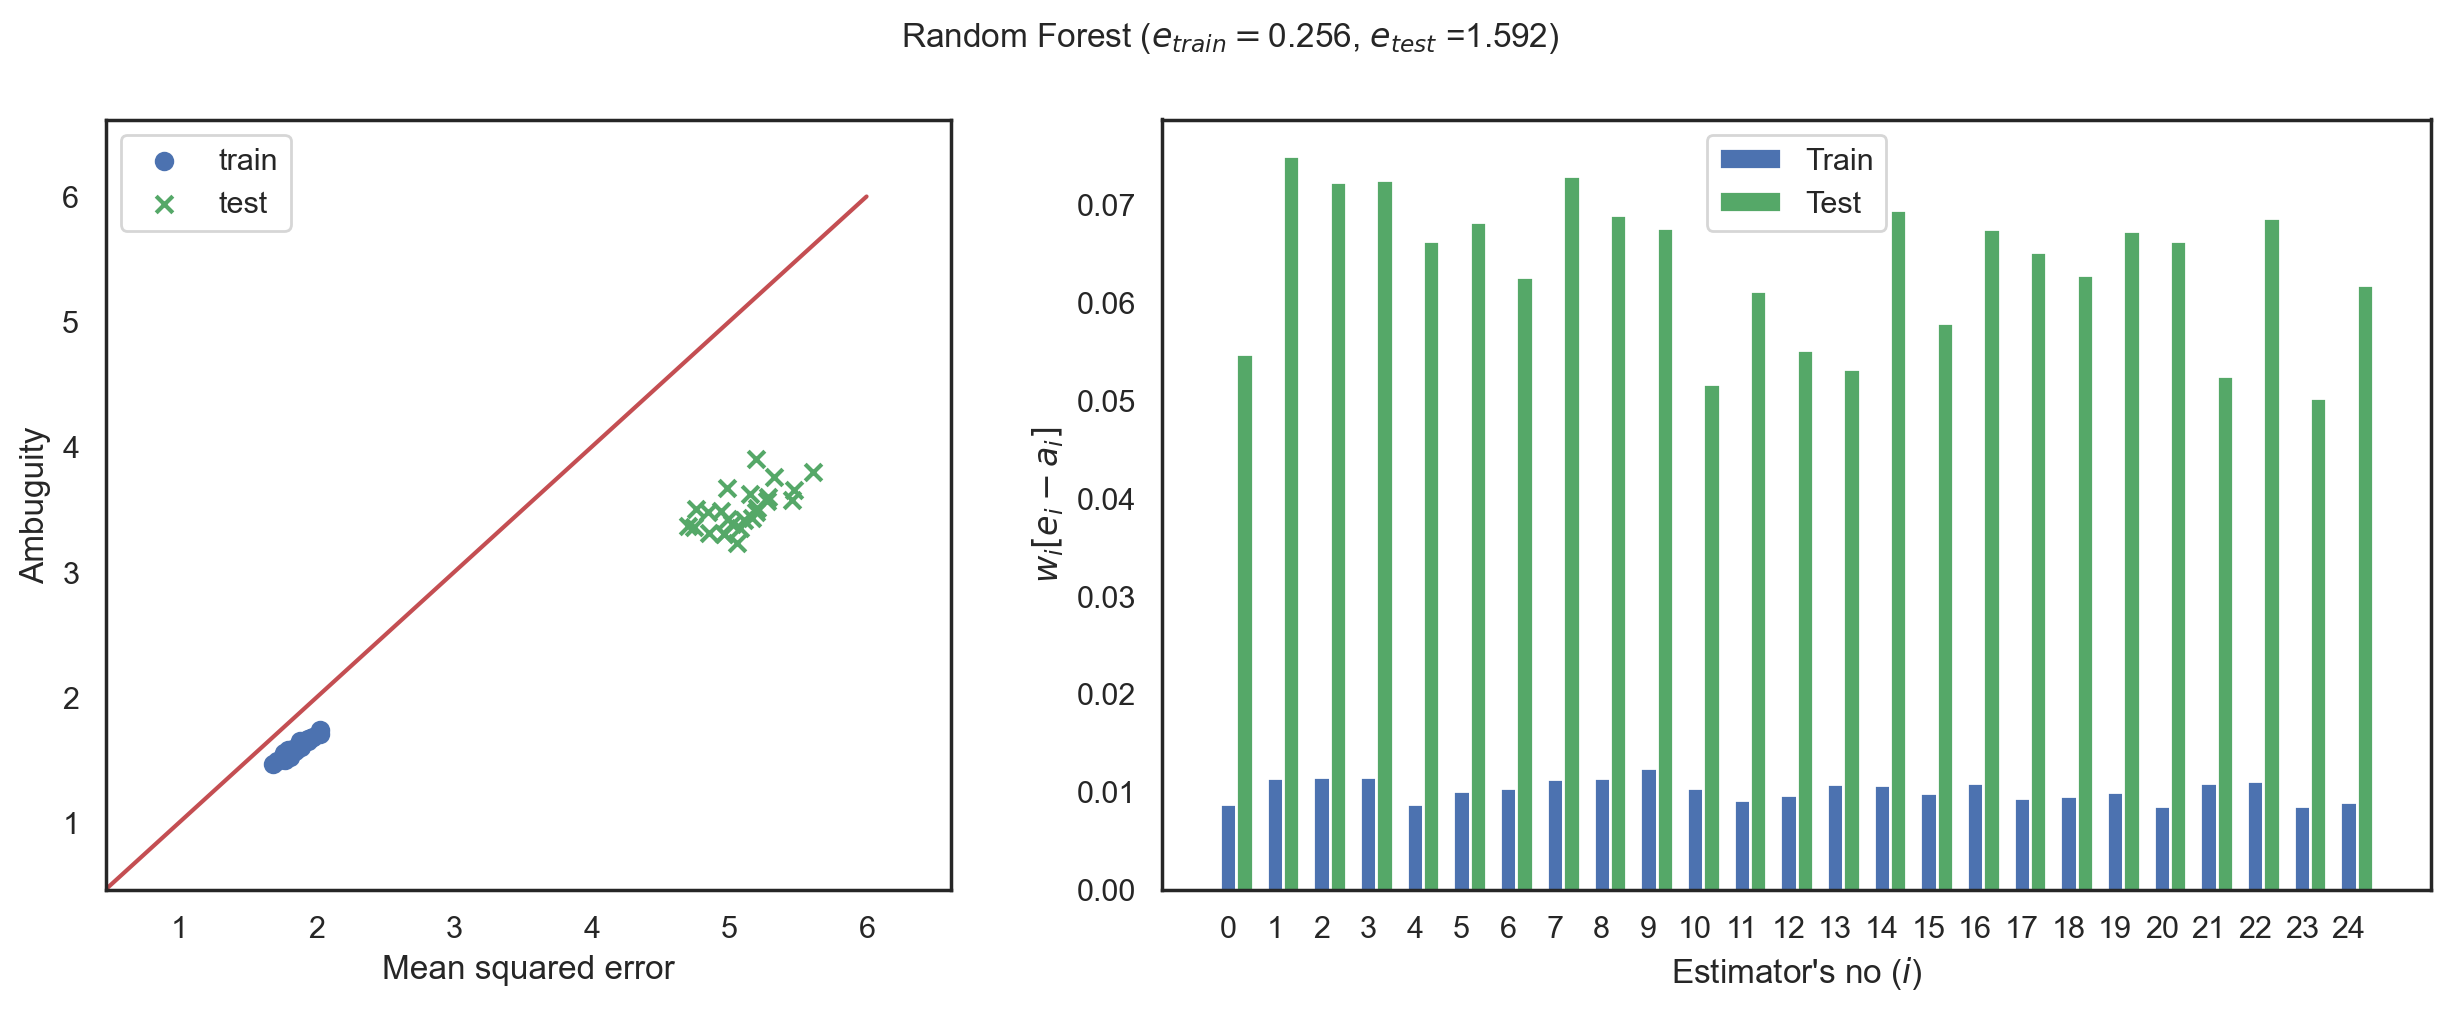

In [225]:
mse_amb_plot(models25['rf'],'Random Forest', X_train, y_train, X_test, y_test)

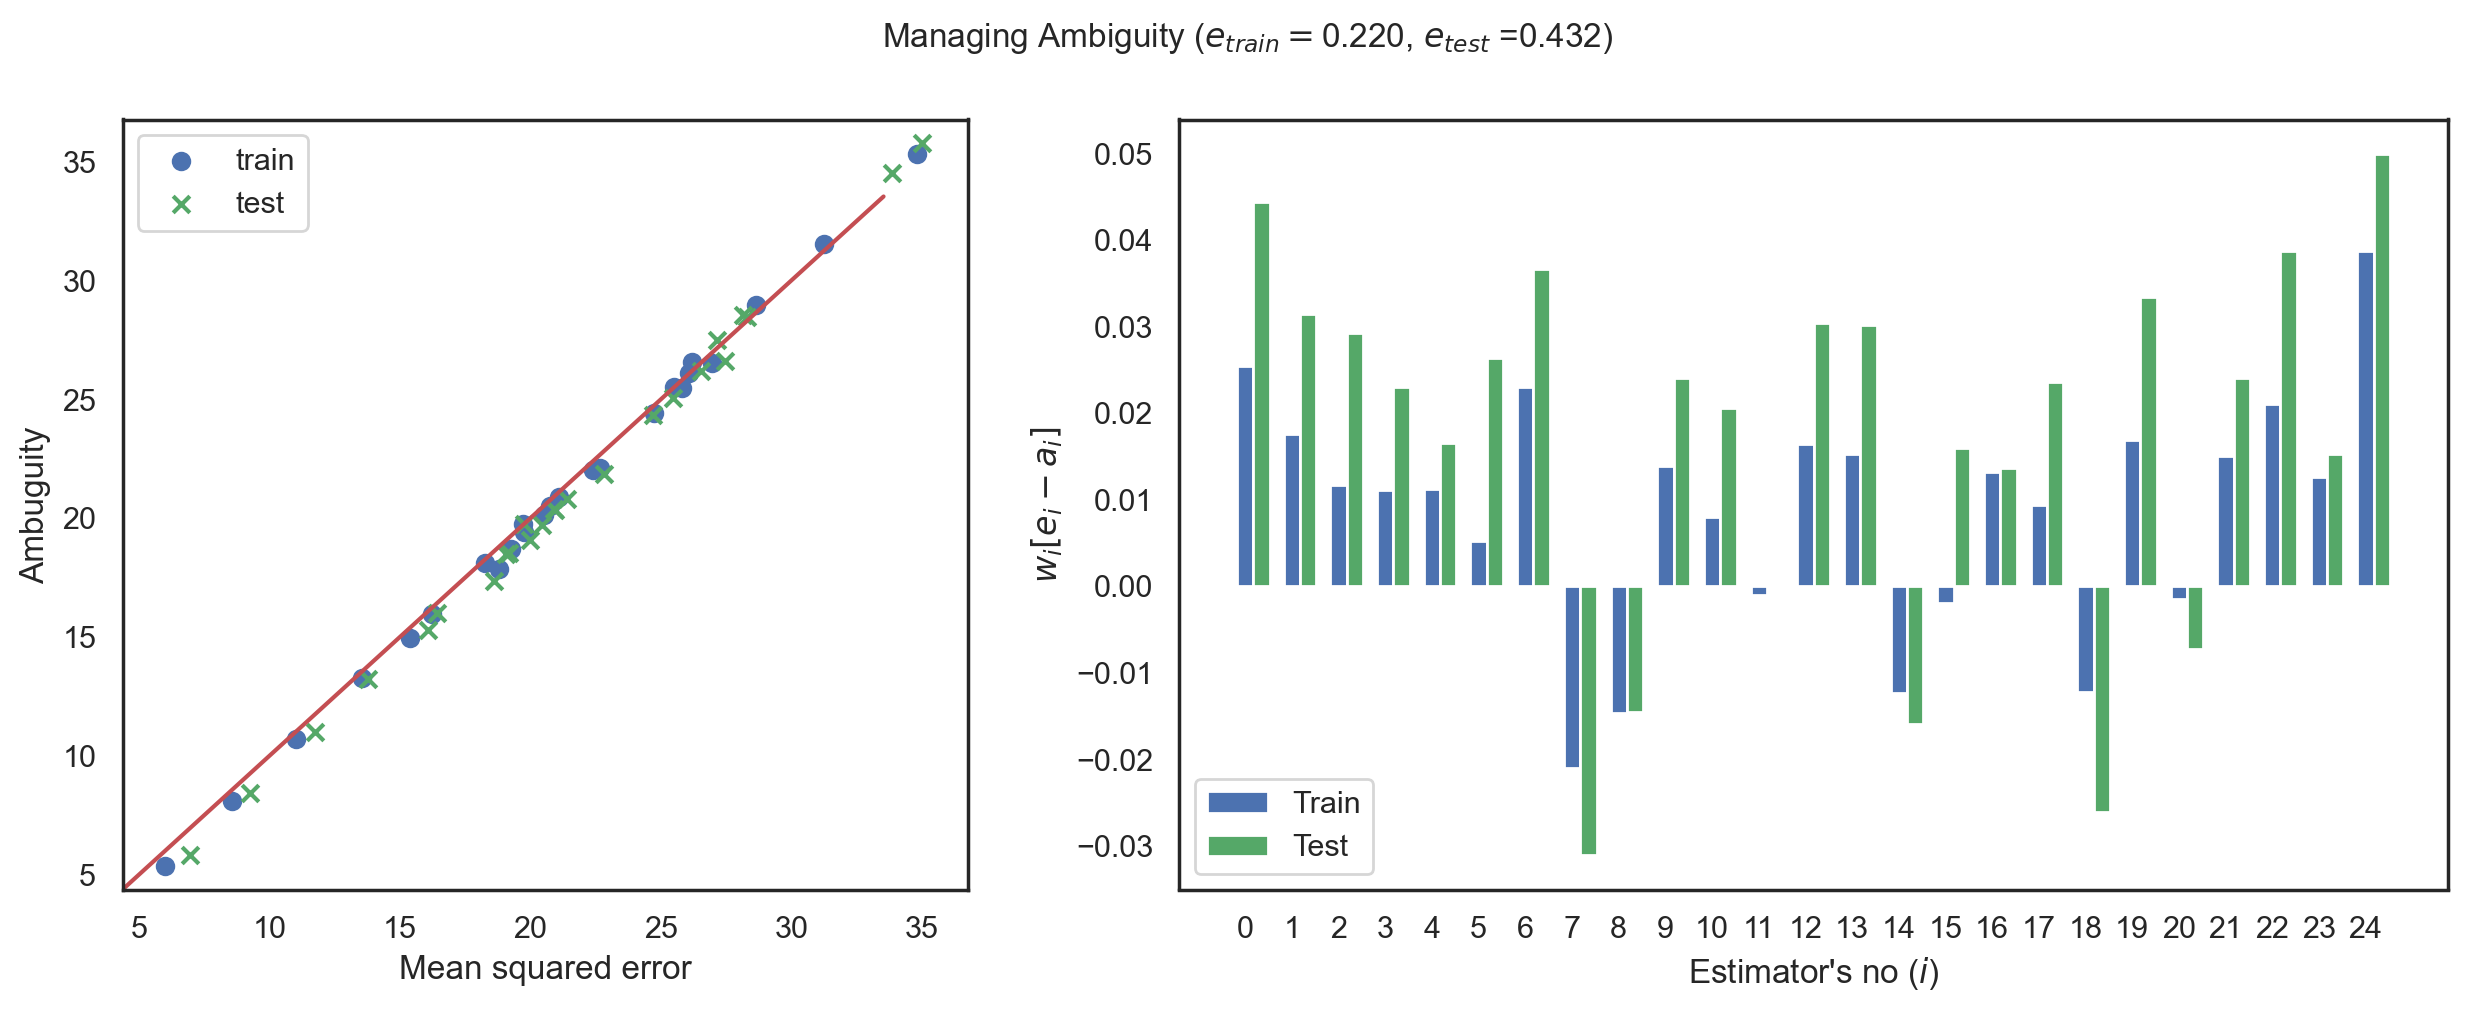

In [226]:
mse_amb_plot(models25['ma'],'Managing Ambiguity', X_train, y_train, X_test, y_test)

#### Estimators correlation¶

In [ ]:
def estimators_correlation(model,X_train, X_test):
    d = {}
    for i,e in enumerate(model.estimators_):
        if type(model) == sklearn.ensemble._gb.GradientBoostingRegressor:
            d[str(i)] = e[0].predict(X)
        else:
            d[str(i)] = e.predict(X)
    df = pd.DataFrame(d)
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
#    print('R2 = %.3f' %corr.mean().mean())    
    sns.heatmap(corr, annot = False, mask = mask, vmin = -1.0, vmax = 1.0, center = 0, fmt=".2f", linewidths=.5, ax=ax)
    ax.set_title(title + ' $R^2$ = %.3f' %corr.mean().mean())

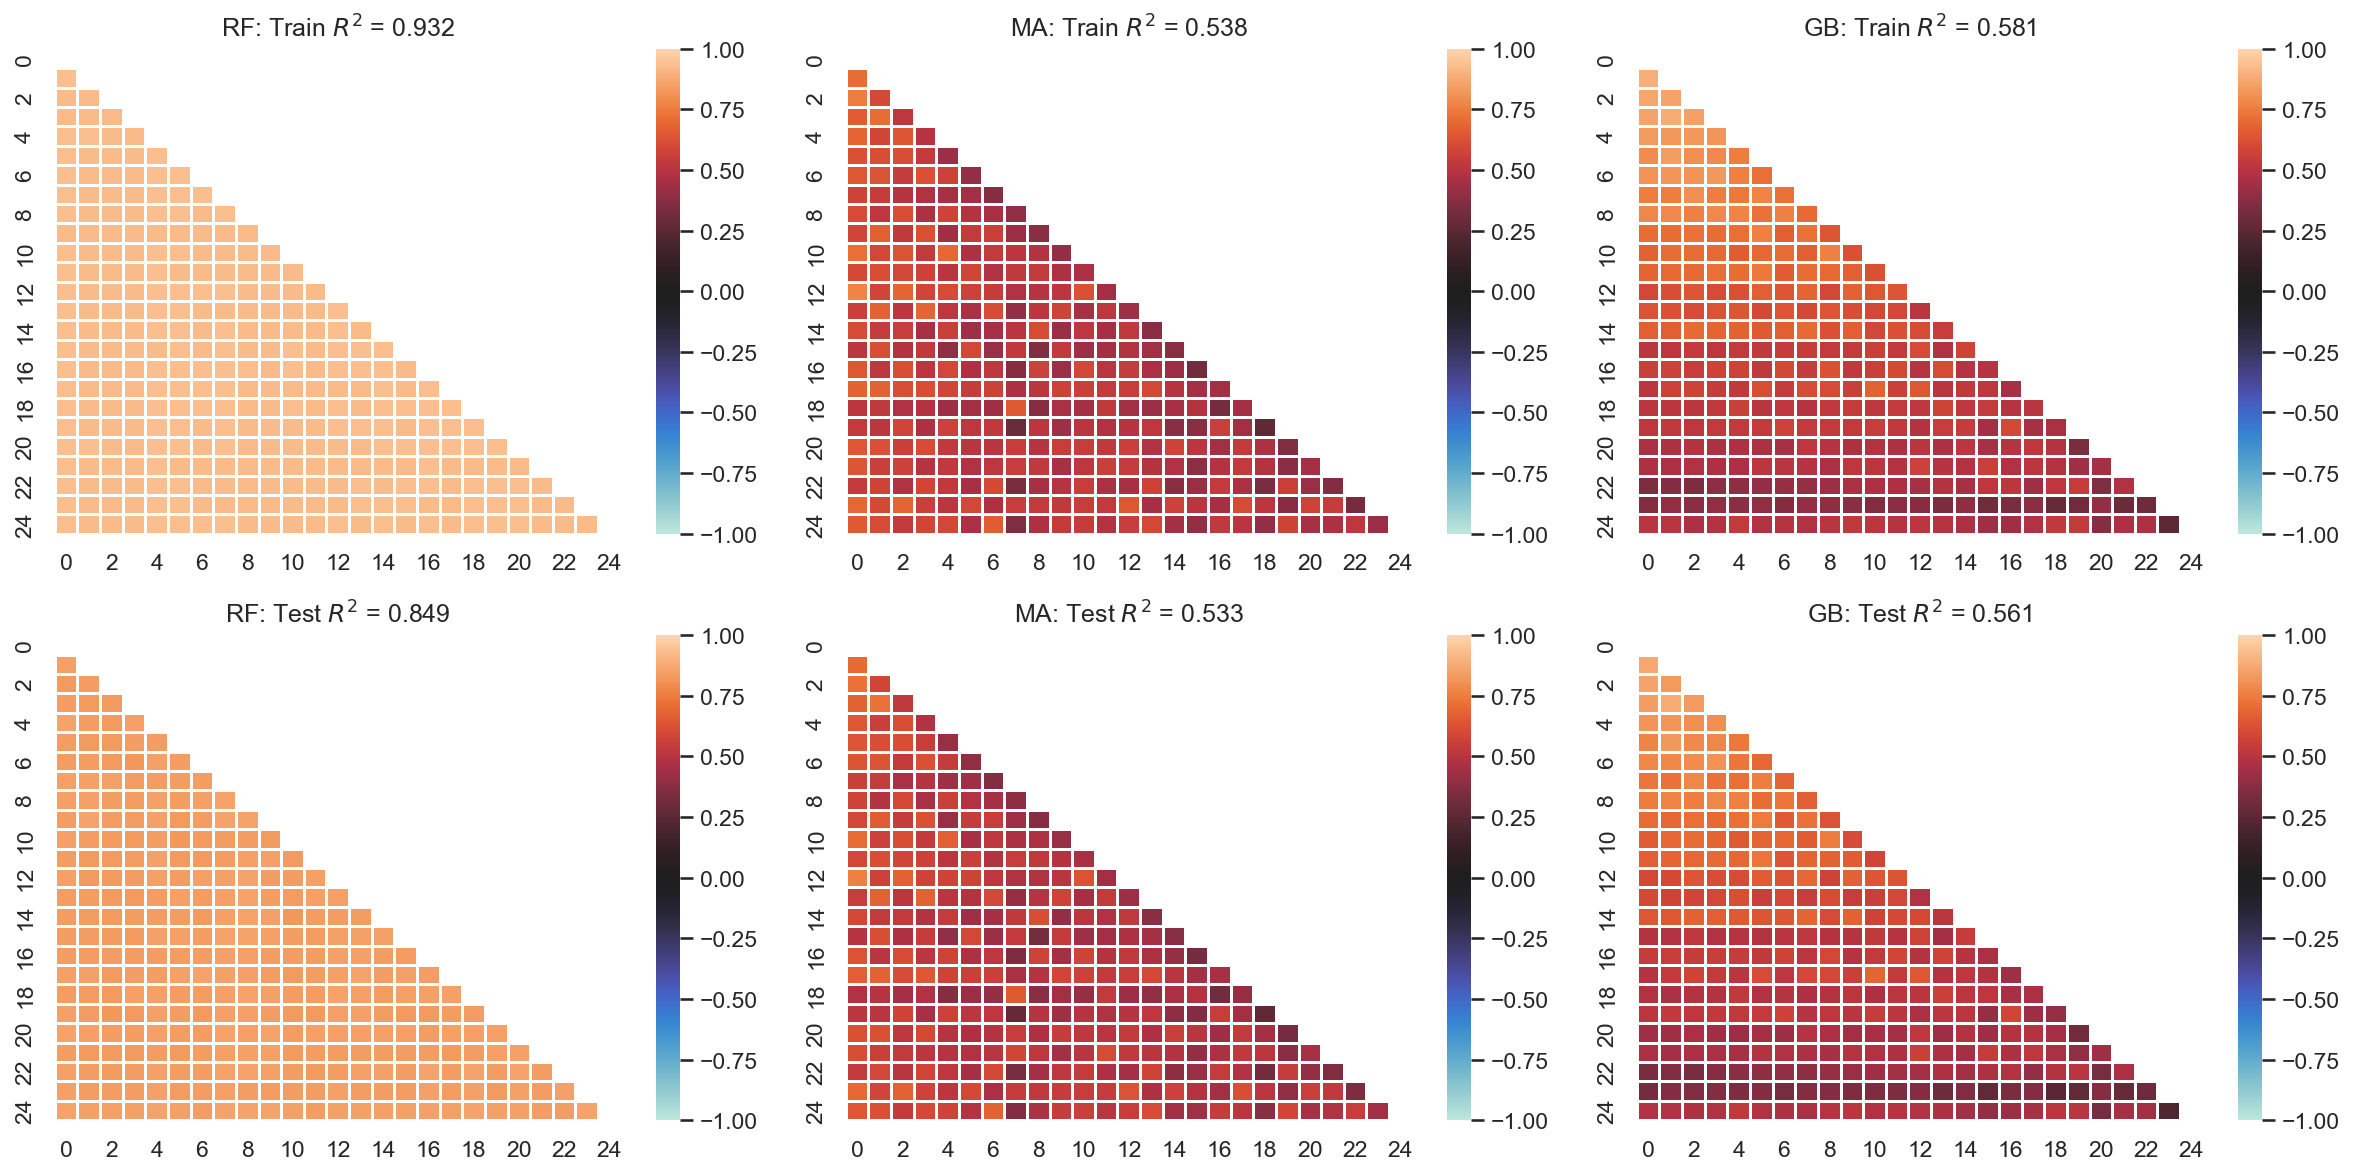

In [245]:
import seaborn as sns

sns.set_theme(style="white")

def diversity_map(model,X, ax, title):
    d = {}
    for i,e in enumerate(model.estimators_):
        if type(model) == sklearn.ensemble._gb.GradientBoostingRegressor:
            d[str(i)] = e[0].predict(X)
        else:
            d[str(i)] = e.predict(X)
    df = pd.DataFrame(d)
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
#    print('R2 = %.3f' %corr.mean().mean())    
    sns.heatmap(corr, annot = False, mask = mask, vmin = -1.0, vmax = 1.0, center = 0, fmt=".2f", linewidths=.5, ax=ax)
    ax.set_title(title + ' $R^2$ = %.3f' %corr.mean().mean())


fig, axes = plt.subplots(2,3, figsize = (16,8), dpi = 150)

diversity_map(models25['rf'],X_train, ax = axes[0,0], title = 'RF: Train')
diversity_map(models25['rf'],X_test,  ax = axes[1,0], title = 'RF: Test')

diversity_map(models25['ma'],X_train, ax = axes[0,1], title = 'MA: Train')
diversity_map(models25['ma'],X_test,  ax = axes[1,1], title = 'MA: Test')

diversity_map(models25['gb'],X_train, ax = axes[0,2], title = 'GB: Train')
diversity_map(models25['gb'],X_test,  ax = axes[1,2], title = 'GB: Test')

fig.tight_layout();